## 使用注意力和MLP
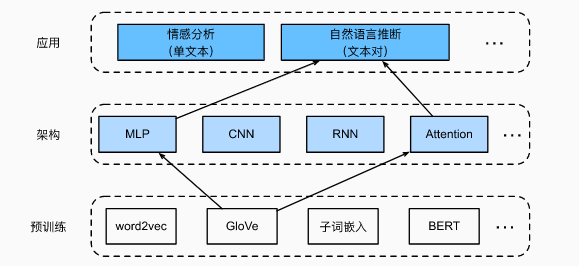
## 模型
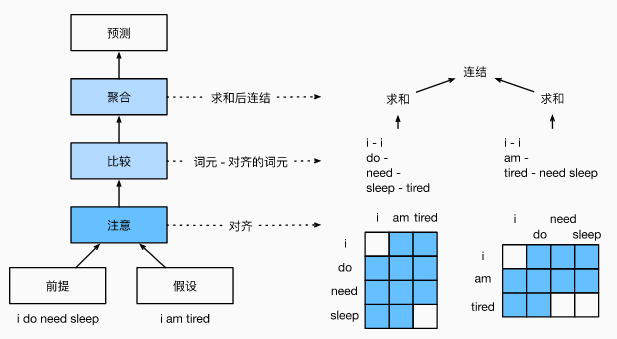

## Attending
* $\mathbf{A} = (\mathbf{a}_1, \ldots, \mathbf{a}_m)$,$\mathbf{B} = (\mathbf{b}_1, \ldots, \mathbf{b}_n)$

* $\mathbf{a}_i, \mathbf{b}_j \in \mathbb{R}^{d}(i = 1, \ldots, m, j = 1, \ldots, n)$ 

* $e_{ij} = f(\mathbf{a}_i)^\top f(\mathbf{b}_j),$

* $\boldsymbol{\beta}_i = \sum_{j=1}^{n}\frac{\exp(e_{ij})}{ \sum_{k=1}^{n} \exp(e_{ik})} \mathbf{b}_j.$

* $\boldsymbol{\alpha}_j = \sum_{i=1}^{m}\frac{\exp(e_{ij})}{ \sum_{k=1}^{m} \exp(e_{kj})} \mathbf{a}_i.$

## Comparing
* \begin{split}\mathbf{v}_{A,i} = g([\mathbf{a}_i, \boldsymbol{\beta}_i]), i = 1, \ldots, m\\ \mathbf{v}_{B,j} = g([\mathbf{b}_j, \boldsymbol{\alpha}_j]), j = 1, \ldots, n.\end{split}

## Aggregating
* $\mathbf{v}_A = \sum_{i=1}^{m} \mathbf{v}_{A,i}, \quad \mathbf{v}_B = \sum_{j=1}^{n}\mathbf{v}_{B,j}.$
* $\hat{\mathbf{y}} = h([\mathbf{v}_A, \mathbf{v}_B]).$

In [16]:
import torch
from torch import nn
from torch.nn import functional as F
import dltools

In [2]:
def mlp(num_inputs, num_hiddens, flatten):
    net = []
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_inputs, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_hiddens, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    return nn.Sequential(*net)

In [3]:
class Attend(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Attend, self).__init__(**kwargs)
        self.f = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B):
        # A/B的形状：（批量大小，序列A/B的词元数，embed_size）
        # f_A/f_B的形状：（批量大小，序列A/B的词元数，num_hiddens）
        f_A = self.f(A) # 256 * 50 *200  256 * 200 * 50
        f_B = self.f(B) 
        # e的形状：（批量大小，序列A的词元数，序列B的词元数）
        e = torch.bmm(f_A, f_B.permute(0, 2, 1))  # 256 * 50 *50
        # beta的形状：（批量大小，序列A的词元数，embed_size），
        # 意味着序列B被软对齐到序列A的每个词元(beta的第1个维度)
        beta = torch.bmm(F.softmax(e, dim=-1), B) # 256 * 50 *200
        # alpha的形状：（批量大小，序列B的词元数，embed_size），
        # 意味着序列A被软对齐到序列B的每个词元(alpha的第1个维度)
        alpha = torch.bmm(F.softmax(e.permute(0, 2, 1), dim=-1), A)
        return beta, alpha

In [4]:
class Compare(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Compare, self).__init__(**kwargs)
        self.g = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B, beta, alpha):
        V_A = self.g(torch.cat([A, beta], dim=2))
        V_B = self.g(torch.cat([B, alpha], dim=2))
        return V_A, V_B

In [5]:
class Aggregate(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs, **kwargs):
        super(Aggregate, self).__init__(**kwargs)
        self.h = mlp(num_inputs, num_hiddens, flatten=True)
        self.linear = nn.Linear(num_hiddens, num_outputs)

    def forward(self, V_A, V_B):
        # 对两组比较向量分别求和
        V_A = V_A.sum(dim=1)
        V_B = V_B.sum(dim=1)
        # 将两个求和结果的连结送到多层感知机中
        Y_hat = self.linear(self.h(torch.cat([V_A, V_B], dim=1)))
        return Y_hat

In [6]:
class DecomposableAttention(nn.Module):
    def __init__(self, vocab, embed_size, num_hiddens, num_inputs_attend=100,num_inputs_compare=200, num_inputs_agg=400, **kwargs):
        super(DecomposableAttention, self).__init__(**kwargs)
        self.embedding = nn.Embedding(len(vocab), embed_size)
        self.attend = Attend(num_inputs_attend, num_hiddens)
        self.compare = Compare(num_inputs_compare, num_hiddens)
        # 有3种可能的输出：蕴涵、矛盾和中性
        self.aggregate = Aggregate(num_inputs_agg, num_hiddens, num_outputs=3)

    def forward(self, X):
        premises, hypotheses = X
        A = self.embedding(premises) # 256 X 50 X 100
        B = self.embedding(hypotheses) # 
        beta, alpha = self.attend(A, B)
        V_A, V_B = self.compare(A, B, beta, alpha) #256 *50 * 400
        Y_hat = self.aggregate(V_A, V_B) # 256 * 3
        return Y_hat

In [7]:
batch_size, num_steps = 256, 50
train_iter, test_iter, vocab = dltools.load_data_snli(batch_size, num_steps)

read 549367 examples
read 9824 examples


In [14]:
# 创建模型
embed_size, num_hiddens, devices = 100, 200, dltools.try_all_gpus()
net = DecomposableAttention(vocab, embed_size, num_hiddens)
glove_embedding = dltools.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds);

loss 0.568, train acc 0.772, test acc 0.808
287.3 examples/sec on [device(type='cpu')]


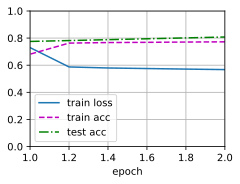

In [17]:
# 训练和评估模型
lr, num_epochs = 0.001, 2
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
dltools.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,devices)

In [18]:
# 使用模型
def predict_snli(net, vocab, premise, hypothesis):
    """预测前提和假设之间的逻辑关系"""
    net.eval()
    premise = torch.tensor(vocab[premise], device=dltools.try_gpu())
    hypothesis = torch.tensor(vocab[hypothesis], device=dltools.try_gpu())
    label = torch.argmax(net([premise.reshape((1, -1)),hypothesis.reshape((1, -1))]), dim=1)
    return 'entailment' if label == 0 else 'contradiction' if label == 1 else 'neutral'

In [19]:
predict_snli(net, vocab, ['he', 'is', 'good', '.'], ['he', 'is', 'bad', '.'])

'contradiction'